In [ ]:
# -*- coding: utf-8 -*-
"""Untitled6.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1WGylAK8f3xbgZ6SopiVWjPhzwNUataVz
"""

import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#loading the file
file_path = '/content/drive/MyDrive/umist_cropped.mat'  # Path to the uploaded file
data = scipy.io.loadmat(file_path)

# extracting image data and labels
facedat = data['facedat']  # Image data for each class
dirnames = data['dirnames']  # Class identifiers

# Flatten the dataset into a usable format
images = []  # To store flattened images
labels = []  # To store corresponding class labels

# Looping through each class in facedat and extract the images
for class_index, class_data in enumerate(facedat[0]):
    num_images = class_data.shape[-1]  # Number of images in the class
    for i in range(num_images):
        images.append(class_data[:, :, i].flatten())  # Flatten each image
        labels.append(class_index)  # Assign the class index as the label

# converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Dataset loaded: {images.shape[0]} samples, each with {images.shape[1]} features.")
print(f"Number of classes: {len(np.unique(labels))}")

# Dataset Splitting
# Split the data into training, validation, and test sets with stratified sampling
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
)  # 0.1765 ensures ~15% validation

print("Dataset Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#Data Preprocessing
# Normalize pixel values to [0, 1]
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Standardize to zero mean and unit variance
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_norm)
X_val_std = scaler.transform(X_val_norm)
X_test_std = scaler.transform(X_test_norm)

print(f"Training set mean (after standardization): {X_train_std.mean():.4f}")
print(f"Training set std deviation (after standardization): {X_train_std.std():.4f}")

# Dimensionality Reduction with PCA
# Retain 99% variance
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_std)  # Fit and transform training data
X_val_pca = pca.transform(X_val_std)          # Apply PCA transformation to validation data
X_test_pca = pca.transform(X_test_std)        # Apply PCA transformation to test data

print("PCA Transformation:")
print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Reduced feature dimension: {X_train_pca.shape[1]}")
print(f"Explained Variance Ratio (PCA): {pca.explained_variance_ratio_.sum():.4f}")

Dataset loaded: 575 samples, each with 10304 features.
Number of classes: 20
Dataset Split:
Training set: 401 samples
Validation set: 87 samples
Test set: 87 samples
Training set mean (after standardization): -0.0000
Training set std deviation (after standardization): 1.0000
PCA Transformation:
Original feature dimension: 10304
Reduced feature dimension: 248
Explained Variance Ratio (PCA): 0.9901


KMeans Evaluation:
Adjusted Rand Index (ARI): 0.3445
Normalized Mutual Information (NMI): 0.7394
Silhouette Score: 0.1673

DBSCAN Evaluation: No clusters found; try tuning `eps` and `min_samples`.

Gaussian Mixture Models (GMM) Evaluation:
Adjusted Rand Index (ARI): 0.3445
Normalized Mutual Information (NMI): 0.7394
Silhouette Score: 0.1673

Agglomerative Hierarchical Clustering Evaluation:
Adjusted Rand Index (ARI): 0.3742
Normalized Mutual Information (NMI): 0.7452
Silhouette Score: 0.2113


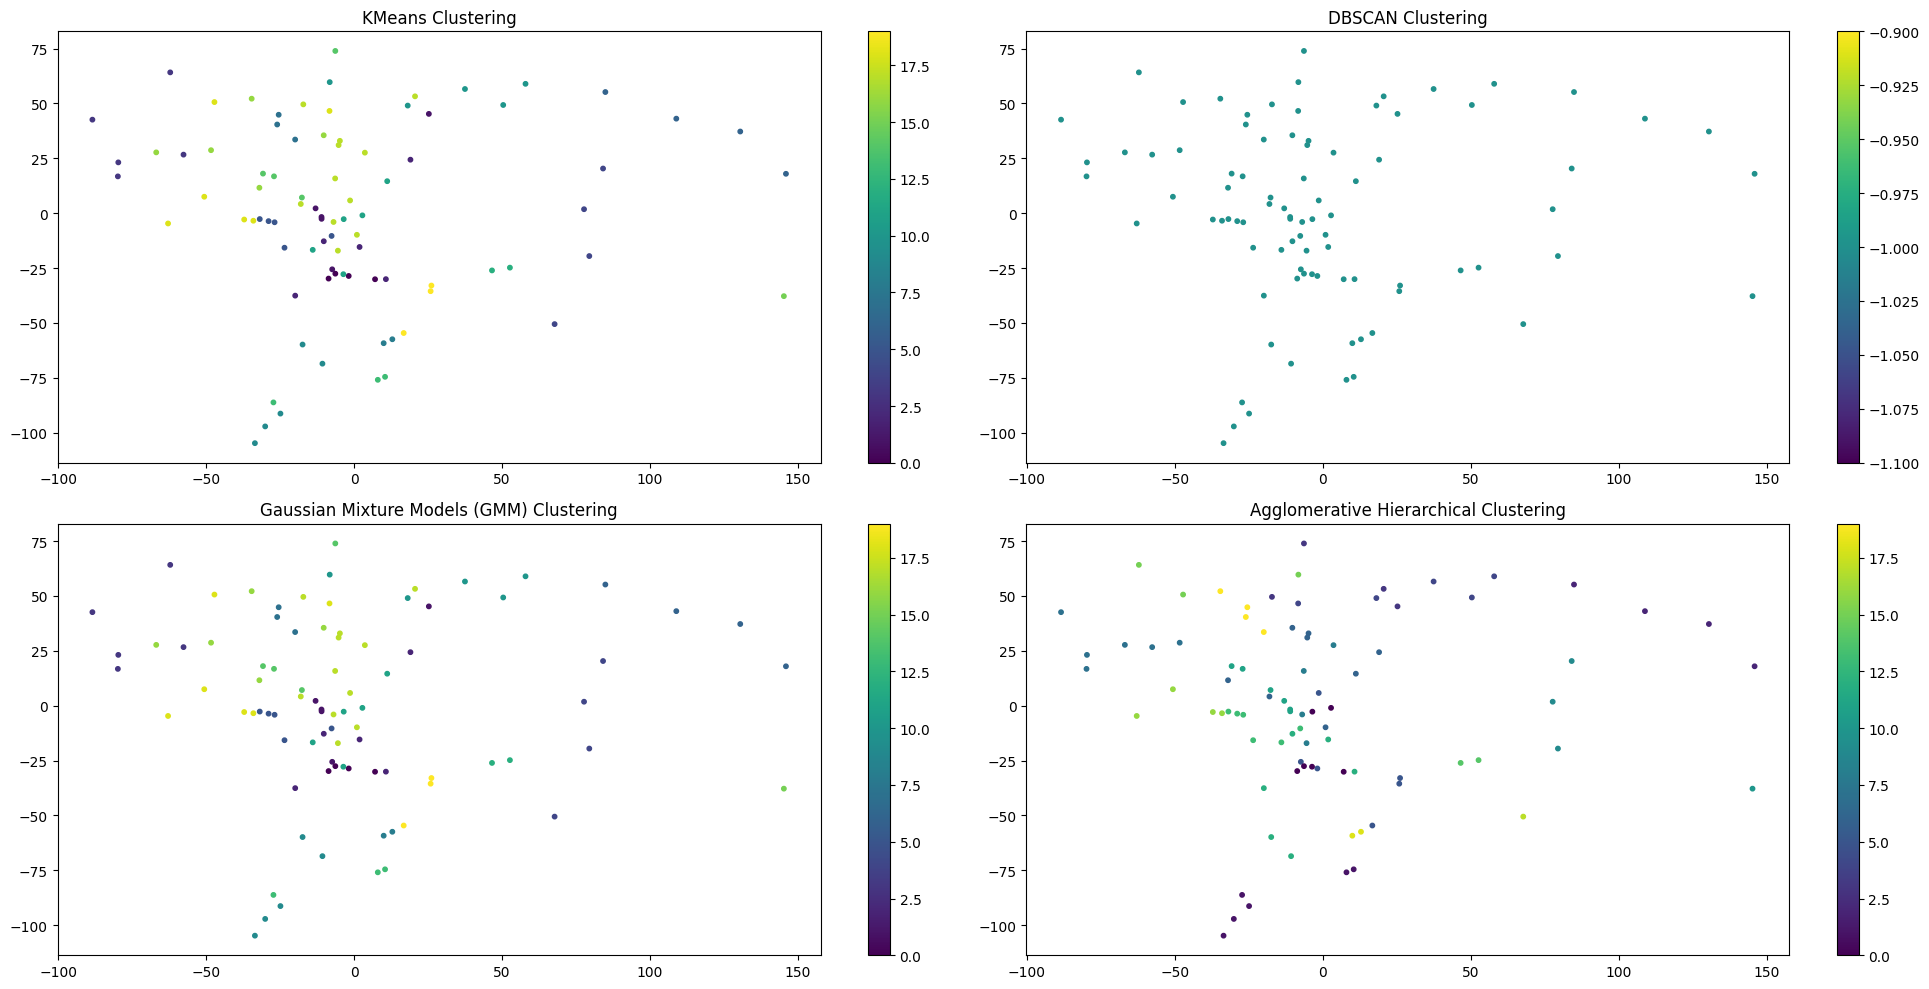

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Number of clusters based on the number of classes
n_clusters = len(np.unique(labels))

# Apply KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_test_pca)

# Evaluate KMeans
kmeans_ari = adjusted_rand_score(y_test, kmeans_labels)
kmeans_nmi = normalized_mutual_info_score(y_test, kmeans_labels)
kmeans_silhouette = silhouette_score(X_test_pca, kmeans_labels)

print("KMeans Evaluation:")
print(f"Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
print(f"Normalized Mutual Information (NMI): {kmeans_nmi:.4f}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")

# Apply DBSCAN
eps = 20  # You might need to tune this
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_test_pca)

# Evaluate DBSCAN
dbscan_labels_no_noise = dbscan_labels[dbscan_labels != -1]
y_test_no_noise = y_test[dbscan_labels != -1]

if len(np.unique(dbscan_labels)) > 1:  # Check if DBSCAN found clusters
    dbscan_ari = adjusted_rand_score(y_test_no_noise, dbscan_labels_no_noise)
    dbscan_nmi = normalized_mutual_info_score(y_test_no_noise, dbscan_labels_no_noise)
    dbscan_silhouette = silhouette_score(X_test_pca[dbscan_labels != -1], dbscan_labels_no_noise)

    print("\nDBSCAN Evaluation:")
    print(f"Adjusted Rand Index (ARI): {dbscan_ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {dbscan_nmi:.4f}")
    print(f"Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("\nDBSCAN Evaluation: No clusters found; try tuning `eps` and `min_samples`.")

# Apply Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_test_pca)

# Evaluate GMM
gmm_ari = adjusted_rand_score(y_test, gmm_labels)
gmm_nmi = normalized_mutual_info_score(y_test, gmm_labels)
gmm_silhouette = silhouette_score(X_test_pca, gmm_labels)

print("\nGaussian Mixture Models (GMM) Evaluation:")
print(f"Adjusted Rand Index (ARI): {gmm_ari:.4f}")
print(f"Normalized Mutual Information (NMI): {gmm_nmi:.4f}")
print(f"Silhouette Score: {gmm_silhouette:.4f}")

# Apply Agglomerative Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(X_test_pca)

# Evaluate Agglomerative Clustering
agglo_ari = adjusted_rand_score(y_test, agglo_labels)
agglo_nmi = normalized_mutual_info_score(y_test, agglo_labels)
agglo_silhouette = silhouette_score(X_test_pca, agglo_labels)

print("\nAgglomerative Hierarchical Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {agglo_ari:.4f}")
print(f"Normalized Mutual Information (NMI): {agglo_nmi:.4f}")
print(f"Silhouette Score: {agglo_silhouette:.4f}")

# Visualization
# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
X_test_2d = pca_2d.fit_transform(X_test_pca)

plt.figure(figsize=(20, 10))

# Plot KMeans results
plt.subplot(2, 2, 1)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.colorbar()

# Plot DBSCAN results
plt.subplot(2, 2, 2)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clustering")
plt.colorbar()

# Plot GMM results
plt.subplot(2, 2, 3)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Gaussian Mixture Models (GMM) Clustering")
plt.colorbar()

# Plot Agglomerative Clustering results
plt.subplot(2, 2, 4)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=agglo_labels, cmap='viridis', s=10)
plt.title("Agglomerative Hierarchical Clustering")
plt.colorbar()

plt.tight_layout()
plt.show()
